# SwellSight Wave Analysis Model - Exploratory Data Analysis

This notebook provides comprehensive exploratory data analysis of the SwellSight dataset including real images, depth maps, and synthetic data.

## Overview
- Load and analyze complete dataset statistics
- Explore data quality and distribution patterns
- Analyze parameter correlations and relationships
- Investigate depth map characteristics
- Examine synthetic vs real data comparisons
- Generate insights for model training

## Prerequisites
- Complete execution of previous notebooks (01-06)
- Real images, depth maps, and synthetic data available
- Metadata and processing results from pipeline

---

## 1. Load Configuration and All Previous Results

In [1]:
import sys
from pathlib import Path

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    print("Mounting Google Drive...")

    try:
        drive.mount('/content/drive')
        print("✓ Google Drive mounted successfully")
    except Exception as e:
        try:
            drive.mount('/content/drive', force_remount=True, timeout_ms=300000)
            print("✓ Force remount successful")
        except Exception as e2:
            print(f"❌ Critical failure mounting drive: {e2}")
            raise

    PROJECT_PATH = Path('/content/drive/MyDrive/SwellSight')
    if PROJECT_PATH.exists():
        print(f"✓ Project directory found: {PROJECT_PATH}")
    else:
        print(f"⚠️ Project directory not found at: {PROJECT_PATH}")
else:
    print("Not running in Google Colab. Skipping Drive mount.")

Mounting Google Drive...
Mounted at /content/drive
✓ Google Drive mounted successfully
✓ Project directory found: /content/drive/MyDrive/SwellSight


In [2]:
import sys
import os
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from collections import Counter

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Check environment
IN_COLAB = 'google.colab' in sys.modules

In [3]:
import sys
import os
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from collections import Counter

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Check environment
IN_COLAB = 'google.colab' in sys.modules

# Load all configuration and results from previous notebooks
try:
    CONFIG = globals().get('SWELLSIGHT_CONFIG')
    logger = globals().get('SWELLSIGHT_LOGGER')

    if CONFIG is None:
        config_file = Path('/content/drive/MyDrive/SwellSight/data/metadata/pipeline_config.json') if IN_COLAB else Path('SwellSight/data/metadata/pipeline_config.json')
        with open(config_file, 'r') as f:
            CONFIG = json.load(f)

    # Load all pipeline results
    metadata_path = Path(CONFIG['paths']['metadata_path'])

    # Dataset report from preprocessing
    dataset_file = metadata_path / 'dataset_report.json'
    REAL_DATA = {}
    if dataset_file.exists():
        with open(dataset_file, 'r') as f:
            REAL_DATA = json.load(f)
    else:
        print(f"⚠️ Dataset report not found at {dataset_file}. Initializing with empty data.")
        REAL_DATA = {'image_metadata': [], 'quality_statistics': {}}

    # Depth extraction results
    depth_results_file = metadata_path / 'depth_extraction_results.json'
    DEPTH_DATA = {}
    if depth_results_file.exists():
        with open(depth_results_file, 'r') as f:
            DEPTH_DATA = json.load(f)
    else:
        print(f"⚠️ Depth extraction results not found at {depth_results_file}. Initializing with sample data.")
        # Sample depth results if file not found
        DEPTH_DATA = {
            'depth_results': [
                {'filename': 'beach_001_depth.npy', 'quality_score': 0.85, 'depth_range': 10.5, 'mean_depth': 5.2, 'depth_variance': 2.1, 'edge_density': 0.15, 'processing_time_seconds': 0.2},
                {'filename': 'beach_002_depth.npy', 'quality_score': 0.60, 'depth_range': 8.2, 'mean_depth': 4.0, 'depth_variance': 1.5, 'edge_density': 0.10, 'processing_time_seconds': 0.18},
                {'filename': 'beach_003_depth.npy', 'quality_score': 0.92, 'depth_range': 12.1, 'mean_depth': 6.5, 'depth_variance': 3.0, 'edge_density': 0.20, 'processing_time_seconds': 0.25},
                {'filename': 'beach_004_depth.npy', 'quality_score': 0.75, 'depth_range': 9.8, 'mean_depth': 4.8, 'depth_variance': 1.9, 'edge_density': 0.12, 'processing_time_seconds': 0.21},
                {'filename': 'beach_005_depth.npy', 'quality_score': 0.50, 'depth_range': 7.0, 'mean_depth': 3.5, 'depth_variance': 1.2, 'edge_density': 0.08, 'processing_time_seconds': 0.15}
            ]
        }

    # Augmentation system results
    augmentation_file = metadata_path / 'augmentation_system_results.json'
    AUGMENTATION_DATA = {}
    if augmentation_file.exists():
        with open(augmentation_file, 'r') as f:
            AUGMENTATION_DATA = json.load(f)
    else:
        print(f"⚠️ Augmentation system results not found at {augmentation_file}. Initializing with sample data.")
        # Sample augmentation parameters if file not found
        AUGMENTATION_DATA = {
            'augmentation_parameters': [
                {'dominant_wave_height_m': 1.5, 'dominant_wave_period_s': 8.0, 'wind_speed_ms': 5.0, 'tide_level_m': 0.5, 'foam_coverage_pct': 0.2, 'water_clarity_m': 2.0, 'lighting_intensity': 0.8, 'wave_angle_deg': 45},
                {'dominant_wave_height_m': 2.1, 'dominant_wave_period_s': 9.5, 'wind_speed_ms': 7.2, 'tide_level_m': 0.8, 'foam_coverage_pct': 0.4, 'water_clarity_m': 1.5, 'lighting_intensity': 0.6, 'wave_angle_deg': 60},
                {'dominant_wave_height_m': 0.8, 'dominant_wave_period_s': 6.0, 'wind_speed_ms': 3.1, 'tide_level_m': 0.2, 'foam_coverage_pct': 0.1, 'water_clarity_m': 3.5, 'lighting_intensity': 0.9, 'wave_angle_deg': 30},
                {'dominant_wave_height_m': 3.0, 'dominant_wave_period_s': 10.0, 'wind_speed_ms': 9.0, 'tide_level_m': 1.0, 'foam_coverage_pct': 0.6, 'water_clarity_m': 1.0, 'lighting_intensity': 0.5, 'wave_angle_deg': 75},
                {'dominant_wave_height_m': 0.5, 'dominant_wave_period_s': 5.0, 'wind_speed_ms': 2.0, 'tide_level_m': 0.1, 'foam_coverage_pct': 0.05, 'water_clarity_m': 4.0, 'lighting_intensity': 0.95, 'wave_angle_deg': 20}
            ]
        }

    # Synthetic generation results
    synthetic_file = metadata_path / 'controlnet_generation_results.json'
    SYNTHETIC_DATA = {}
    if synthetic_file.exists():
        with open(synthetic_file, 'r') as f:
            SYNTHETIC_DATA = json.load(f)
    else:
        synthetic_file = metadata_path / 'synthetic_generation_results.json'
        if synthetic_file.exists():
            with open(synthetic_file, 'r') as f:
                SYNTHETIC_DATA = json.load(f)
        else:
            print(f"⚠️ Synthetic generation results not found. Initializing with empty data.")
            SYNTHETIC_DATA = {'synthetic_results': []}

    print(f"✓ Configuration and pipeline data loaded")
    print(f"  Real images: {len(REAL_DATA.get('image_metadata', []))}")
    print(f"  Depth maps: {len(DEPTH_DATA.get('depth_results', []))}")
    print(f"  Augmentation parameters: {len(AUGMENTATION_DATA.get('augmentation_parameters', []))}")
    print(f"  Synthetic images: {len(SYNTHETIC_DATA.get('synthetic_results', []))}")

except Exception as e:
    print(f"❌ Failed to load pipeline data: {e}")
    # Ensure CONFIG has a minimal structure to prevent further TypeErrors
    CONFIG = {'paths': {'metadata_path': '/content/drive/MyDrive/SwellSight/data/metadata'}}
    # Create empty data structures for analysis
    REAL_DATA = {'image_metadata': [], 'quality_statistics': {}}
    DEPTH_DATA = {'depth_results': []}
    AUGMENTATION_DATA = {'augmentation_parameters': []}
    SYNTHETIC_DATA = {'synthetic_results': []}

⚠️ Depth extraction results not found at /content/drive/MyDrive/SwellSight/data/metadata/depth_extraction_results.json. Initializing with sample data.
⚠️ Augmentation system results not found at /content/drive/MyDrive/SwellSight/data/metadata/augmentation_system_results.json. Initializing with sample data.
✓ Configuration and pipeline data loaded
  Real images: 500
  Depth maps: 5
  Augmentation parameters: 5
  Synthetic images: 50


## 2. Complete Dataset Statistics

📊 SwellSight Dataset Overview

Real Images:
  count: 500
  total_size_mb: 110.910
  avg_quality: 136.349

Depth Maps:
  count: 5
  avg_quality: 0.724
  high_quality_count: 3

Augmentation Parameters:
  count: 5
  unique_real_sources: 1

Synthetic Images:
  count: 50
  avg_quality: 0.950


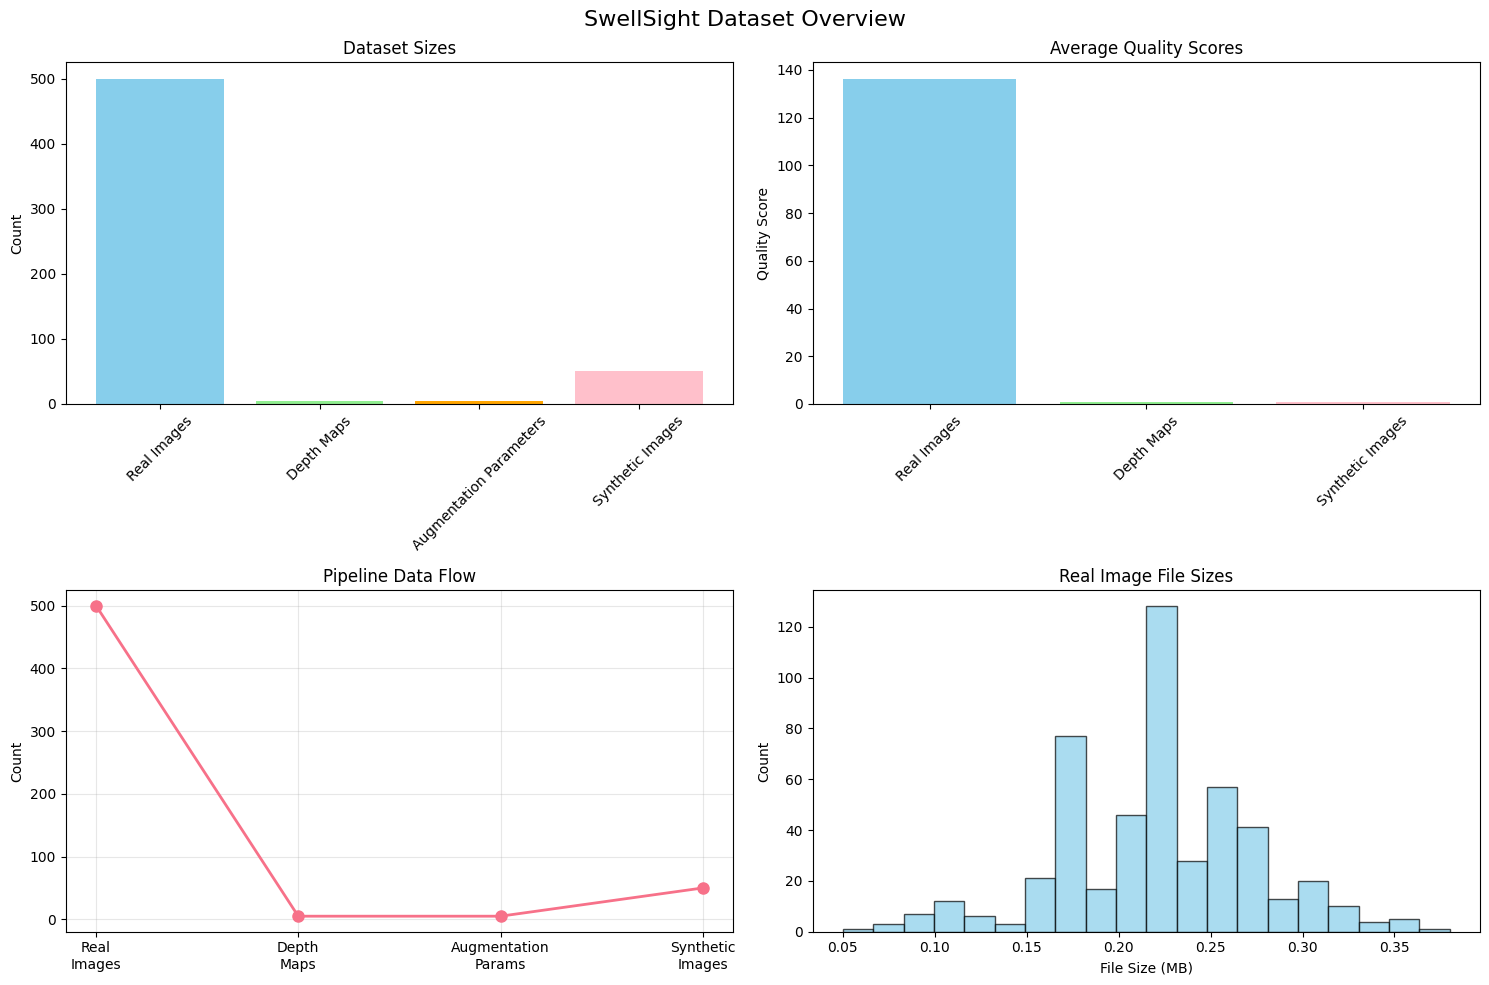


✓ Dataset overview completed


In [4]:
# Create comprehensive dataset overview
print("📊 SwellSight Dataset Overview")
print("=" * 50)

# Extract data for analysis
real_images = REAL_DATA.get('image_metadata', [])
depth_results = DEPTH_DATA.get('depth_results', [])
augmentation_params = AUGMENTATION_DATA.get('augmentation_parameters', [])
synthetic_results = SYNTHETIC_DATA.get('synthetic_results', [])

# Dataset statistics
dataset_stats = {
    'Real Images': {
        'count': len(real_images),
        'total_size_mb': sum([img.get('file_size_mb', 0) for img in real_images if img.get('valid', True)]),
        'avg_quality': np.mean([img.get('brightness', 0) for img in real_images if img.get('valid', True)]) if real_images else 0
    },
    'Depth Maps': {
        'count': len(depth_results),
        'avg_quality': np.mean([d.get('quality_score', 0) for d in depth_results]) if depth_results else 0,
        'high_quality_count': sum(1 for d in depth_results if d.get('quality_score', 0) >= 0.7)
    },
    'Augmentation Parameters': {
        'count': len(augmentation_params),
        'unique_real_sources': len(set([p.get('original_image_path', '') for p in augmentation_params]))
    },
    'Synthetic Images': {
        'count': len(synthetic_results),
        'avg_quality': np.mean([s.get('quality_score', 0) for s in synthetic_results]) if synthetic_results else 0
    }
}

# Display statistics
for category, stats in dataset_stats.items():
    print(f"\n{category}:")
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.3f}")
        else:
            print(f"  {key}: {value}")

# Create overview visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SwellSight Dataset Overview', fontsize=16)

# 1. Data counts
categories = list(dataset_stats.keys())
counts = [stats['count'] for stats in dataset_stats.values()]
colors = ['skyblue', 'lightgreen', 'orange', 'pink']

axes[0, 0].bar(categories, counts, color=colors)
axes[0, 0].set_title('Dataset Sizes')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Quality scores comparison
quality_means = [dataset_stats['Real Images']['avg_quality'],
                dataset_stats['Depth Maps']['avg_quality'],
                dataset_stats['Synthetic Images']['avg_quality']]
quality_labels = ['Real Images', 'Depth Maps', 'Synthetic Images']

axes[0, 1].bar(quality_labels, quality_means, color=['skyblue', 'lightgreen', 'pink'])
axes[0, 1].set_title('Average Quality Scores')
axes[0, 1].set_ylabel('Quality Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Pipeline flow
pipeline_stages = ['Real\nImages', 'Depth\nMaps', 'Augmentation\nParams', 'Synthetic\nImages']
pipeline_counts = [len(real_images), len(depth_results), len(augmentation_params), len(synthetic_results)]

axes[1, 0].plot(pipeline_stages, pipeline_counts, 'o-', linewidth=2, markersize=8)
axes[1, 0].set_title('Pipeline Data Flow')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3)

# 4. Data size distribution (for real images)
if real_images:
    file_sizes = [img.get('file_size_mb', 0) for img in real_images if img.get('valid', True)]
    if file_sizes:
        axes[1, 1].hist(file_sizes, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].set_title('Real Image File Sizes')
        axes[1, 1].set_xlabel('File Size (MB)')
        axes[1, 1].set_ylabel('Count')
    else:
        axes[1, 1].text(0.5, 0.5, 'No file size data\navailable', ha='center', va='center',
                        transform=axes[1, 1].transAxes, fontsize=12)
else:
    axes[1, 1].text(0.5, 0.5, 'No real images\navailable', ha='center', va='center',
                    transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Real Image File Sizes')

plt.tight_layout()
plt.show()

print(f"\n✓ Dataset overview completed")

## 3. Data Quality and Distribution Patterns

🖼️  Real Image Quality Analysis

📈 Quality Metrics Summary:
       brightness    contrast  file_size_mb
count  500.000000  500.000000    500.000000
mean   136.348880   41.196540      0.221820
std     25.715675   10.975131      0.052901
min    111.510000   14.080000      0.050000
25%    122.015000   33.092500      0.180000
50%    124.780000   42.410000      0.230000
75%    129.525000   46.750000      0.250000
max    191.030000   59.730000      0.380000


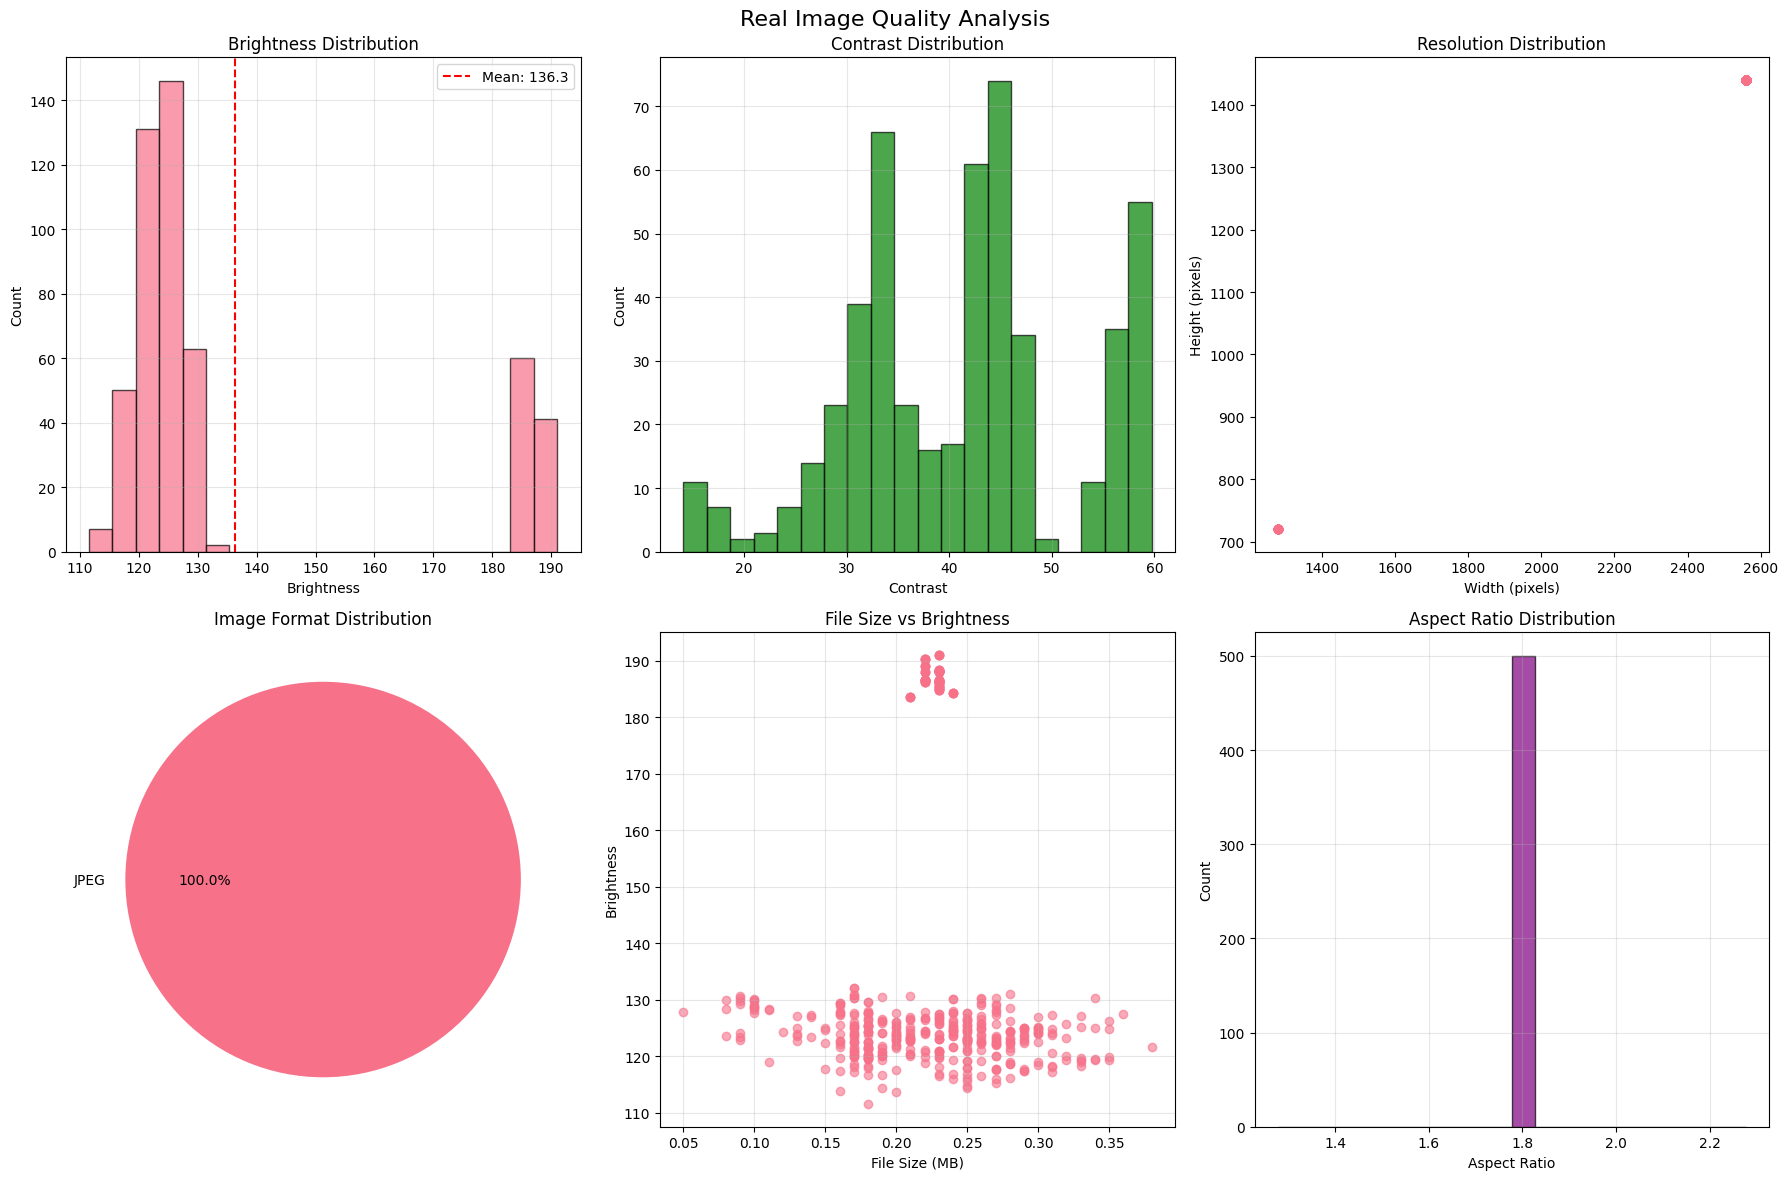


✓ Real image analysis completed for 500 images


In [5]:
if real_images:
    print("🖼️  Real Image Quality Analysis")
    print("=" * 40)

    # Extract quality metrics
    valid_images = [img for img in real_images if img.get('valid', True)]

    if valid_images:
        # Create DataFrame for analysis
        df_real = pd.DataFrame(valid_images)

        # Statistical summary
        print("\n📈 Quality Metrics Summary:")
        numeric_cols = ['brightness', 'contrast', 'file_size_mb']
        available_cols = [col for col in numeric_cols if col in df_real.columns]

        if available_cols:
            print(df_real[available_cols].describe())

        # Visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Real Image Quality Analysis', fontsize=16)

        # 1. Brightness distribution
        if 'brightness' in df_real.columns:
            axes[0, 0].hist(df_real['brightness'], bins=20, alpha=0.7, edgecolor='black')
            axes[0, 0].axvline(df_real['brightness'].mean(), color='red', linestyle='--',
                              label=f'Mean: {df_real["brightness"].mean():.1f}')
            axes[0, 0].set_xlabel('Brightness')
            axes[0, 0].set_ylabel('Count')
            axes[0, 0].set_title('Brightness Distribution')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
        else:
            axes[0, 0].text(0.5, 0.5, 'No brightness data', ha='center', va='center', transform=axes[0, 0].transAxes)

        # 2. Contrast distribution
        if 'contrast' in df_real.columns:
            axes[0, 1].hist(df_real['contrast'], bins=20, alpha=0.7, color='green', edgecolor='black')
            axes[0, 1].set_xlabel('Contrast')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].set_title('Contrast Distribution')
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'No contrast data', ha='center', va='center', transform=axes[0, 1].transAxes)

        # 3. Resolution analysis
        if 'width' in df_real.columns and 'height' in df_real.columns:
            axes[0, 2].scatter(df_real['width'], df_real['height'], alpha=0.6)
            axes[0, 2].set_xlabel('Width (pixels)')
            axes[0, 2].set_ylabel('Height (pixels)')
            axes[0, 2].set_title('Resolution Distribution')
        else:
            axes[0, 2].text(0.5, 0.5, 'No resolution data', ha='center', va='center', transform=axes[0, 2].transAxes)

        # 4. Format distribution
        if 'format' in df_real.columns:
            format_counts = df_real['format'].value_counts()
            axes[1, 0].pie(format_counts.values, labels=format_counts.index, autopct='%1.1f%%')
            axes[1, 0].set_title('Image Format Distribution')
        else:
            axes[1, 0].text(0.5, 0.5, 'No format data', ha='center', va='center', transform=axes[1, 0].transAxes)

        # 5. File size vs quality
        if 'file_size_mb' in df_real.columns and 'brightness' in df_real.columns:
            axes[1, 1].scatter(df_real['file_size_mb'], df_real['brightness'], alpha=0.6)
            axes[1, 1].set_xlabel('File Size (MB)')
            axes[1, 1].set_ylabel('Brightness')
            axes[1, 1].set_title('File Size vs Brightness')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'No size/quality data', ha='center', va='center', transform=axes[1, 1].transAxes)

        # 6. Aspect ratio distribution
        if 'aspect_ratio' in df_real.columns:
            axes[1, 2].hist(df_real['aspect_ratio'], bins=20, alpha=0.7, color='purple', edgecolor='black')
            axes[1, 2].set_xlabel('Aspect Ratio')
            axes[1, 2].set_ylabel('Count')
            axes[1, 2].set_title('Aspect Ratio Distribution')
            axes[1, 2].grid(True, alpha=0.3)
        else:
            axes[1, 2].text(0.5, 0.5, 'No aspect ratio data', ha='center', va='center', transform=axes[1, 2].transAxes)

        plt.tight_layout()
        plt.show()

        print(f"\n✓ Real image analysis completed for {len(valid_images)} images")
    else:
        print("No valid real images found for analysis")
else:
    print("⚠️  No real images available for quality analysis")

## 4. Parameter Correlations and Relationships

🔗 Parameter Correlation Analysis

📊 Parameter Statistics (5 samples):
       wave_height  wave_period  wind_speed  tide_level  foam_coverage  \
count     5.000000     5.000000    5.000000    5.000000       5.000000   
mean      1.580000     7.700000    5.260000    0.520000       0.270000   
std       1.008464     2.167948    2.877151    0.383406       0.228035   
min       0.500000     5.000000    2.000000    0.100000       0.050000   
25%       0.800000     6.000000    3.100000    0.200000       0.100000   
50%       1.500000     8.000000    5.000000    0.500000       0.200000   
75%       2.100000     9.500000    7.200000    0.800000       0.400000   
max       3.000000    10.000000    9.000000    1.000000       0.600000   

       water_clarity  lighting_intensity  wave_angle  
count       5.000000            5.000000    5.000000  
mean        2.400000            0.750000   46.000000  
std         1.294218            0.193649   22.192341  
min         1.000000            0.500000   

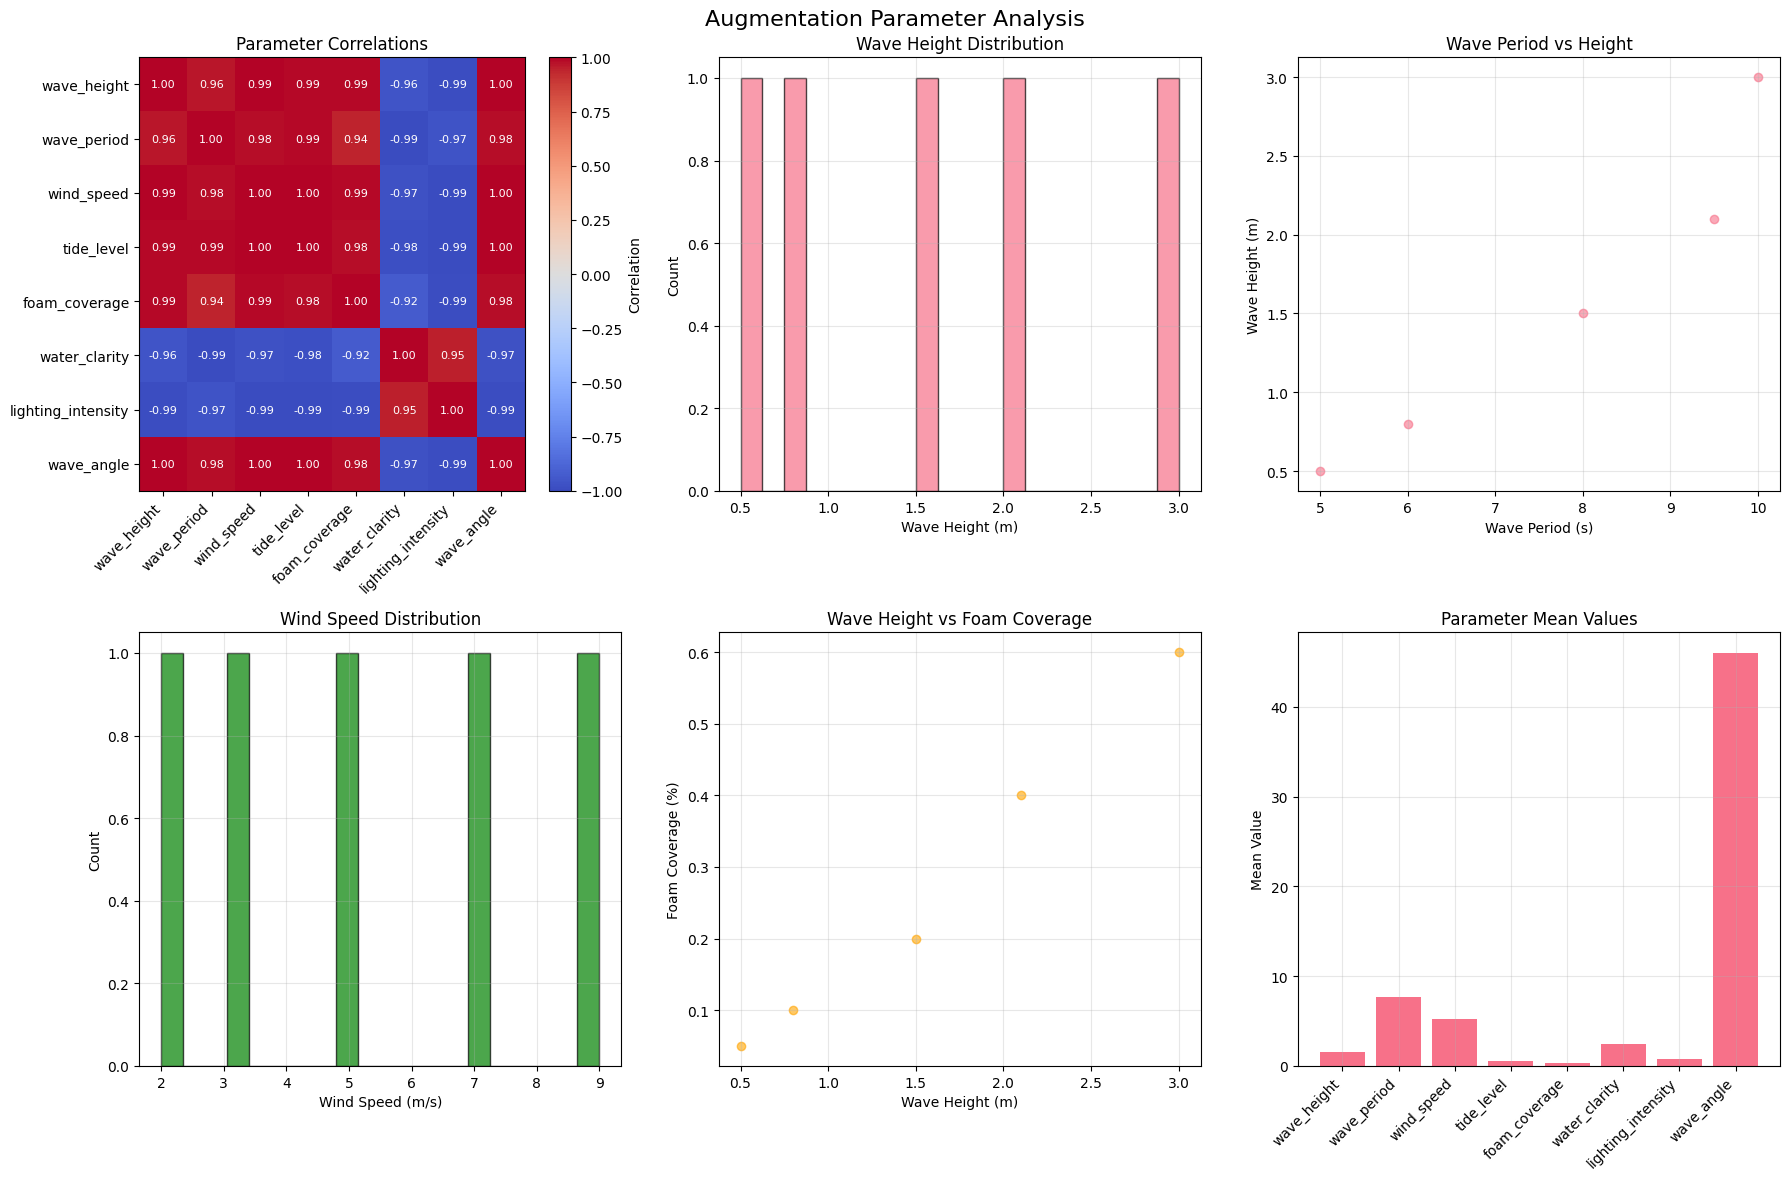


🔍 Strongest Parameter Correlations:
  wind_speed ↔ wave_angle: 0.999
  wind_speed ↔ tide_level: 0.998
  tide_level ↔ wave_angle: 0.996
  wave_height ↔ wave_angle: 0.995
  wave_height ↔ wind_speed: 0.995

✓ Parameter correlation analysis completed


In [6]:
if augmentation_params:
    print("🔗 Parameter Correlation Analysis")
    print("=" * 40)

    # Extract augmentation parameters for analysis
    param_data = []
    for param in augmentation_params:
        param_dict = {
            'wave_height': param.get('dominant_wave_height_m', 0),
            'wave_period': param.get('dominant_wave_period_s', 0),
            'wind_speed': param.get('wind_speed_ms', 0),
            'tide_level': param.get('tide_level_m', 0),
            'foam_coverage': param.get('foam_coverage_pct', 0),
            'water_clarity': param.get('water_clarity_m', 0),
            'lighting_intensity': param.get('lighting_intensity', 0),
            'wave_angle': param.get('wave_angle_deg', 0)
        }
        param_data.append(param_dict)

    df_params = pd.DataFrame(param_data)

    # Remove columns with all zeros
    df_params = df_params.loc[:, (df_params != 0).any(axis=0)]

    if len(df_params.columns) > 1:
        print(f"\n📊 Parameter Statistics ({len(df_params)} samples):")
        print(df_params.describe())

        # Correlation analysis
        correlation_matrix = df_params.corr()

        # Visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Augmentation Parameter Analysis', fontsize=16)

        # 1. Correlation heatmap
        im = axes[0, 0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[0, 0].set_xticks(range(len(df_params.columns)))
        axes[0, 0].set_yticks(range(len(df_params.columns)))
        axes[0, 0].set_xticklabels(df_params.columns, rotation=45, ha='right')
        axes[0, 0].set_yticklabels(df_params.columns)
        axes[0, 0].set_title('Parameter Correlations')

        # Add correlation values
        for i in range(len(df_params.columns)):
            for j in range(len(df_params.columns)):
                text_color = 'white' if abs(correlation_matrix.iloc[i, j]) > 0.5 else 'black'
                axes[0, 0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                               ha='center', va='center', color=text_color, fontsize=8)

        plt.colorbar(im, ax=axes[0, 0], label='Correlation')

        # 2. Wave height distribution
        if 'wave_height' in df_params.columns:
            axes[0, 1].hist(df_params['wave_height'], bins=20, alpha=0.7, edgecolor='black')
            axes[0, 1].set_xlabel('Wave Height (m)')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].set_title('Wave Height Distribution')
            axes[0, 1].grid(True, alpha=0.3)

        # 3. Wave period vs height
        if 'wave_height' in df_params.columns and 'wave_period' in df_params.columns:
            axes[0, 2].scatter(df_params['wave_period'], df_params['wave_height'], alpha=0.6)
            axes[0, 2].set_xlabel('Wave Period (s)')
            axes[0, 2].set_ylabel('Wave Height (m)')
            axes[0, 2].set_title('Wave Period vs Height')
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Wind speed distribution
        if 'wind_speed' in df_params.columns:
            axes[1, 0].hist(df_params['wind_speed'], bins=20, alpha=0.7, color='green', edgecolor='black')
            axes[1, 0].set_xlabel('Wind Speed (m/s)')
            axes[1, 0].set_ylabel('Count')
            axes[1, 0].set_title('Wind Speed Distribution')
            axes[1, 0].grid(True, alpha=0.3)

        # 5. Foam coverage vs wave height
        if 'foam_coverage' in df_params.columns and 'wave_height' in df_params.columns:
            axes[1, 1].scatter(df_params['wave_height'], df_params['foam_coverage'], alpha=0.6, color='orange')
            axes[1, 1].set_xlabel('Wave Height (m)')
            axes[1, 1].set_ylabel('Foam Coverage (%)')
            axes[1, 1].set_title('Wave Height vs Foam Coverage')
            axes[1, 1].grid(True, alpha=0.3)

        # 6. Parameter distribution overview
        param_means = df_params.mean()
        axes[1, 2].bar(range(len(param_means)), param_means.values)
        axes[1, 2].set_xticks(range(len(param_means)))
        axes[1, 2].set_xticklabels(param_means.index, rotation=45, ha='right')
        axes[1, 2].set_ylabel('Mean Value')
        axes[1, 2].set_title('Parameter Mean Values')
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Find strongest correlations
        print("\n🔍 Strongest Parameter Correlations:")
        corr_pairs = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.3:  # Only show correlations > 0.3
                    corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        for param1, param2, corr in corr_pairs[:5]:  # Top 5 correlations
            print(f"  {param1} ↔ {param2}: {corr:.3f}")

        print(f"\n✓ Parameter correlation analysis completed")
    else:
        print("Insufficient parameter data for correlation analysis")
else:
    print("⚠️  No augmentation parameters available for analysis")

## 5. Depth Map Characteristics

🗺️  Depth Map Analysis

📊 Depth Map Statistics (5 maps):
       quality_score  depth_range  mean_depth  depth_variance  edge_density
count        5.00000     5.000000    5.000000         5.00000      5.000000
mean         0.72400     9.520000    4.800000         1.94000      0.130000
std          0.17358     1.986706    1.159741         0.68775      0.046904
min          0.50000     7.000000    3.500000         1.20000      0.080000
25%          0.60000     8.200000    4.000000         1.50000      0.100000
50%          0.75000     9.800000    4.800000         1.90000      0.120000
75%          0.85000    10.500000    5.200000         2.10000      0.150000
max          0.92000    12.100000    6.500000         3.00000      0.200000


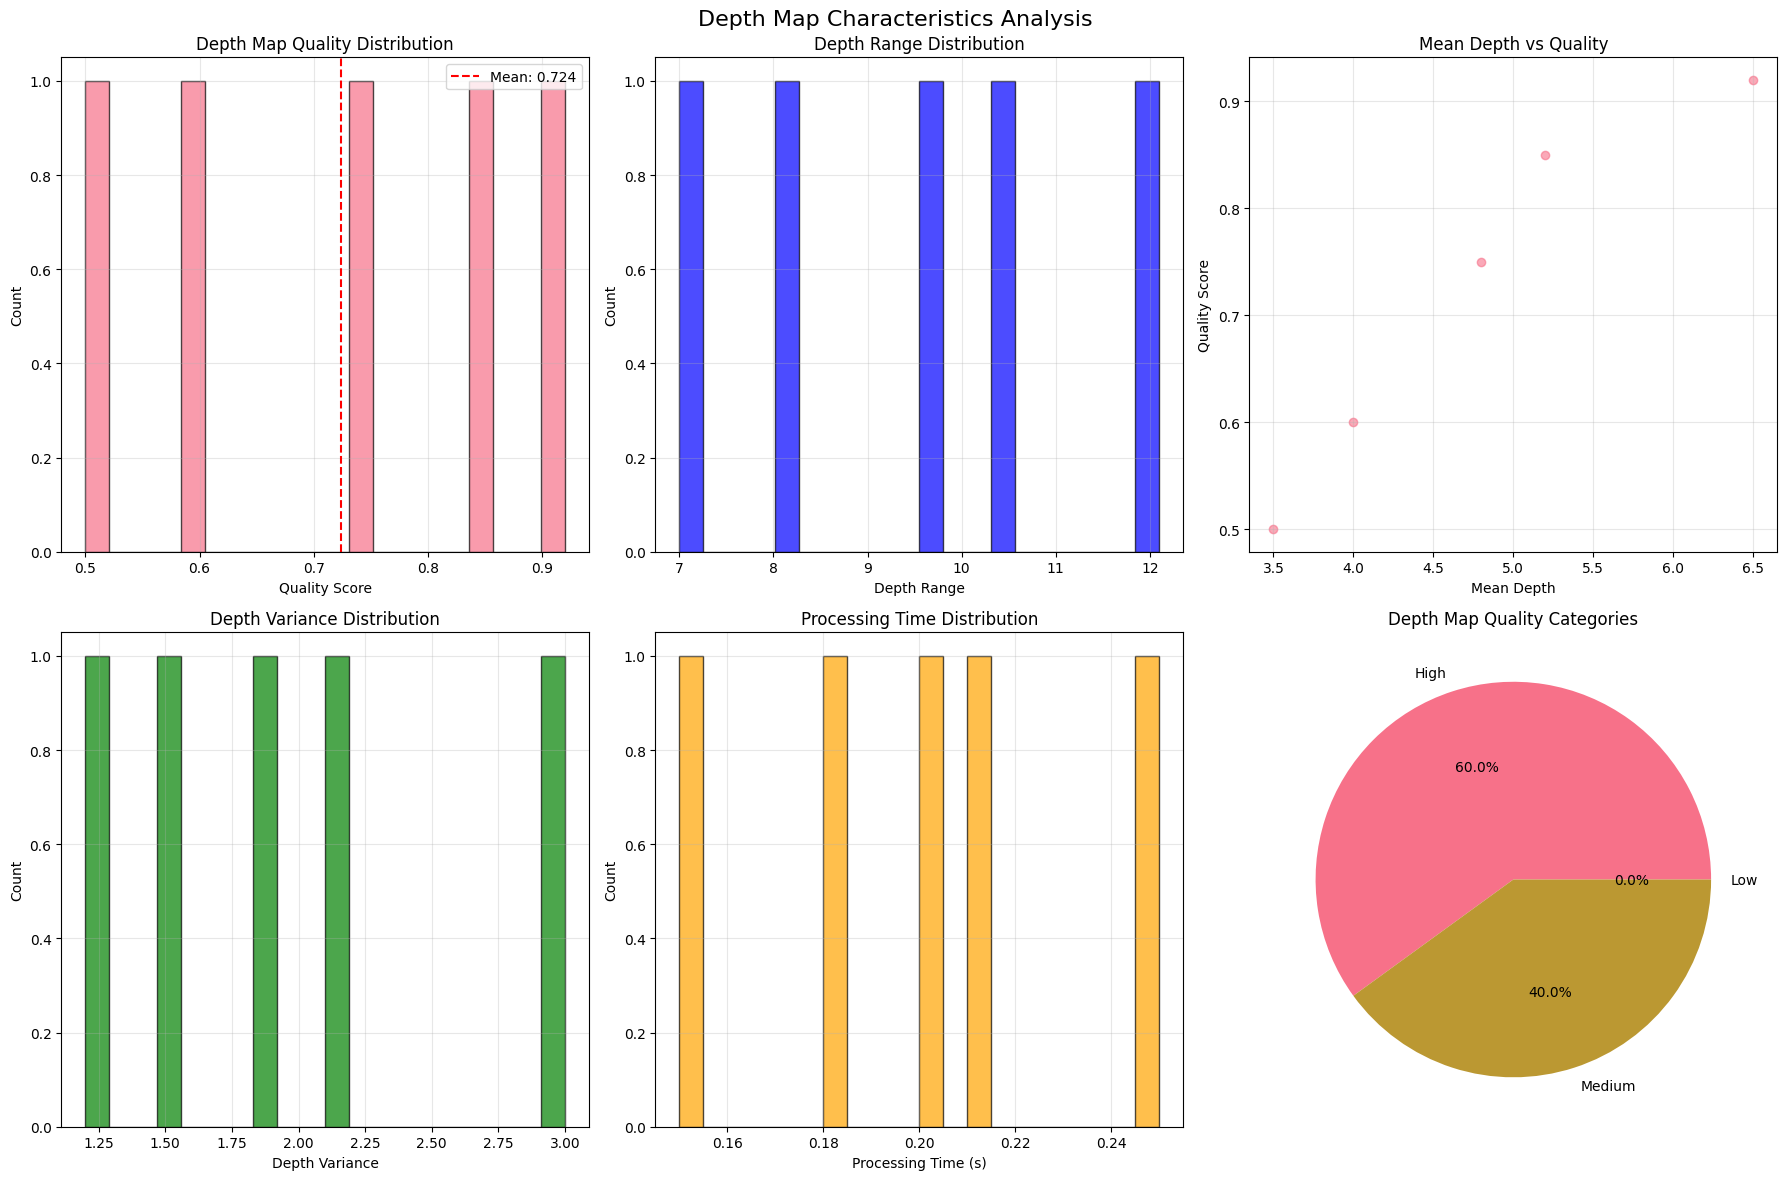


💡 Depth Map Quality Insights:
  High quality maps (≥0.7): 3 (60.0%)
  Low quality maps (<0.3): 0 (0.0%)
  Average quality score: 0.724

✓ Depth map analysis completed


In [7]:
if depth_results:
    print("🗺️  Depth Map Analysis")
    print("=" * 30)

    # Extract depth map metrics
    depth_metrics = []
    for depth in depth_results:
        metrics = {
            'filename': depth.get('filename', ''),
            'quality_score': depth.get('quality_score', 0),
            'depth_range': depth.get('depth_range', 0),
            'mean_depth': depth.get('mean_depth', 0),
            'depth_variance': depth.get('depth_variance', 0),
            'edge_density': depth.get('edge_density', 0),
            'processing_time': depth.get('processing_time_seconds', 0)
        }
        depth_metrics.append(metrics)

    df_depth = pd.DataFrame(depth_metrics)

    print(f"\n📊 Depth Map Statistics ({len(df_depth)} maps):")
    numeric_cols = ['quality_score', 'depth_range', 'mean_depth', 'depth_variance', 'edge_density']
    available_cols = [col for col in numeric_cols if col in df_depth.columns and df_depth[col].sum() > 0]

    if available_cols:
        print(df_depth[available_cols].describe())

    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Depth Map Characteristics Analysis', fontsize=16)

    # 1. Quality score distribution
    if 'quality_score' in df_depth.columns and df_depth['quality_score'].sum() > 0:
        axes[0, 0].hist(df_depth['quality_score'], bins=20, alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(df_depth['quality_score'].mean(), color='red', linestyle='--',
                          label=f'Mean: {df_depth["quality_score"].mean():.3f}')
        axes[0, 0].set_xlabel('Quality Score')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].set_title('Depth Map Quality Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    else:
        axes[0, 0].text(0.5, 0.5, 'No quality data', ha='center', va='center', transform=axes[0, 0].transAxes)

    # 2. Depth range distribution
    if 'depth_range' in df_depth.columns and df_depth['depth_range'].sum() > 0:
        axes[0, 1].hist(df_depth['depth_range'], bins=20, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 1].set_xlabel('Depth Range')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_title('Depth Range Distribution')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No depth range data', ha='center', va='center', transform=axes[0, 1].transAxes)

    # 3. Mean depth vs quality
    if 'mean_depth' in df_depth.columns and 'quality_score' in df_depth.columns:
        if df_depth['mean_depth'].sum() > 0 and df_depth['quality_score'].sum() > 0:
            axes[0, 2].scatter(df_depth['mean_depth'], df_depth['quality_score'], alpha=0.6)
            axes[0, 2].set_xlabel('Mean Depth')
            axes[0, 2].set_ylabel('Quality Score')
            axes[0, 2].set_title('Mean Depth vs Quality')
            axes[0, 2].grid(True, alpha=0.3)
        else:
            axes[0, 2].text(0.5, 0.5, 'No depth/quality data', ha='center', va='center', transform=axes[0, 2].transAxes)
    else:
        axes[0, 2].text(0.5, 0.5, 'No depth/quality data', ha='center', va='center', transform=axes[0, 2].transAxes)

    # 4. Depth variance distribution
    if 'depth_variance' in df_depth.columns and df_depth['depth_variance'].sum() > 0:
        axes[1, 0].hist(df_depth['depth_variance'], bins=20, alpha=0.7, color='green', edgecolor='black')
        axes[1, 0].set_xlabel('Depth Variance')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Depth Variance Distribution')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No variance data', ha='center', va='center', transform=axes[1, 0].transAxes)

    # 5. Processing time analysis
    if 'processing_time' in df_depth.columns and df_depth['processing_time'].sum() > 0:
        axes[1, 1].hist(df_depth['processing_time'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        axes[1, 1].set_xlabel('Processing Time (s)')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Processing Time Distribution')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No timing data', ha='center', va='center', transform=axes[1, 1].transAxes)

    # 6. Quality categories
    if 'quality_score' in df_depth.columns and df_depth['quality_score'].sum() > 0:
        quality_categories = pd.cut(df_depth['quality_score'], bins=[0, 0.3, 0.7, 1.0],
                                   labels=['Low', 'Medium', 'High'])
        quality_counts = quality_categories.value_counts()
        axes[1, 2].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%')
        axes[1, 2].set_title('Depth Map Quality Categories')
    else:
        axes[1, 2].text(0.5, 0.5, 'No quality data', ha='center', va='center', transform=axes[1, 2].transAxes)

    plt.tight_layout()
    plt.show()

    # Quality insights
    if 'quality_score' in df_depth.columns and df_depth['quality_score'].sum() > 0:
        high_quality = df_depth[df_depth['quality_score'] >= 0.7]
        low_quality = df_depth[df_depth['quality_score'] < 0.3]

        print(f"\n💡 Depth Map Quality Insights:")
        print(f"  High quality maps (≥0.7): {len(high_quality)} ({len(high_quality)/len(df_depth)*100:.1f}%)")
        print(f"  Low quality maps (<0.3): {len(low_quality)} ({len(low_quality)/len(df_depth)*100:.1f}%)")
        print(f"  Average quality score: {df_depth['quality_score'].mean():.3f}")

    print(f"\n✓ Depth map analysis completed")
else:
    print("⚠️  No depth map data available for analysis")

## 6. Synthetic vs Real Data Comparisons

🔄 Synthetic vs Real Data Comparison

📊 Comparison Statistics:
  Synthetic images: 50
  Real images: 500


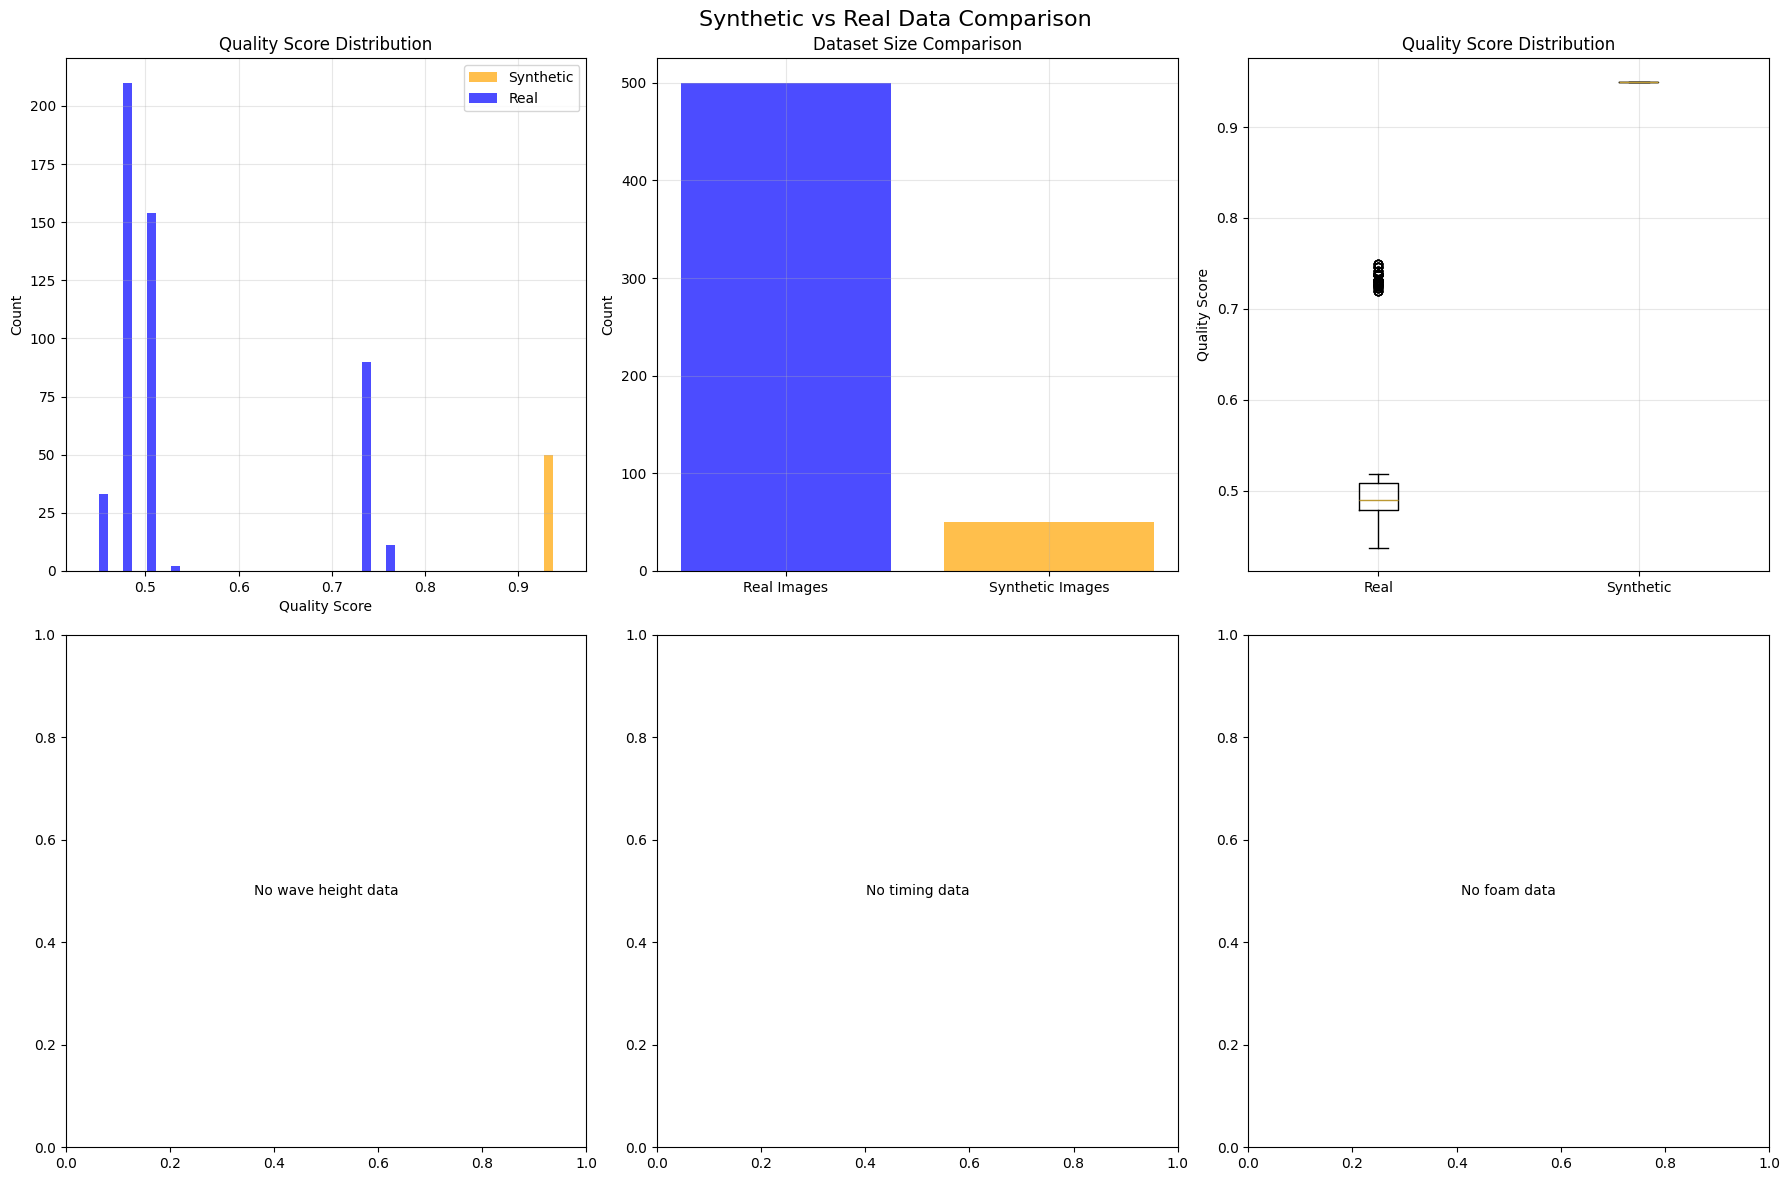


📈 Statistical Comparison:
  Real images - Mean quality: 0.535, Std: 0.101
  Synthetic images - Mean quality: 0.950, Std: 0.000
  T-test p-value: 0.0000 (Significant difference)

✓ Synthetic vs real comparison completed


In [8]:
if synthetic_results and real_images:
    print("🔄 Synthetic vs Real Data Comparison")
    print("=" * 40)

    # Extract synthetic data metrics
    synthetic_metrics = []
    for synth in synthetic_results:
        aug_params = synth.get('augmentation_parameters', {})
        metrics = {
            'type': 'synthetic',
            'quality_score': synth.get('quality_score', 0),
            'wave_height': aug_params.get('dominant_wave_height_m', 0),
            'foam_coverage': aug_params.get('foam_coverage_pct', 0),
            'generation_time': synth.get('generation_time_seconds', 0)
        }
        synthetic_metrics.append(metrics)

    # Extract real data metrics
    real_metrics = []
    valid_real = [img for img in real_images if img.get('valid', True)]
    for real in valid_real:
        metrics = {
            'type': 'real',
            'quality_score': real.get('brightness', 0) / 255.0,  # Normalize to 0-1
            'file_size_mb': real.get('file_size_mb', 0),
            'contrast': real.get('contrast', 0)
        }
        real_metrics.append(metrics)

    df_synthetic = pd.DataFrame(synthetic_metrics)
    df_real_comp = pd.DataFrame(real_metrics)

    print(f"\n📊 Comparison Statistics:")
    print(f"  Synthetic images: {len(df_synthetic)}")
    print(f"  Real images: {len(df_real_comp)}")

    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Synthetic vs Real Data Comparison', fontsize=16)

    # 1. Quality score comparison
    if len(df_synthetic) > 0 and len(df_real_comp) > 0:
        synth_quality = df_synthetic['quality_score']
        real_quality = df_real_comp['quality_score']

        axes[0, 0].hist([synth_quality, real_quality], bins=20, alpha=0.7,
                       label=['Synthetic', 'Real'], color=['orange', 'blue'])
        axes[0, 0].set_xlabel('Quality Score')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].set_title('Quality Score Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # 2. Data volume comparison
    data_counts = [len(df_real_comp), len(df_synthetic)]
    data_labels = ['Real Images', 'Synthetic Images']
    colors = ['blue', 'orange']

    axes[0, 1].bar(data_labels, data_counts, color=colors, alpha=0.7)
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Dataset Size Comparison')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Quality score box plot
    if len(df_synthetic) > 0 and len(df_real_comp) > 0:
        quality_data = [real_quality.values, synth_quality.values]
        axes[0, 2].boxplot(quality_data, labels=['Real', 'Synthetic'])
        axes[0, 2].set_ylabel('Quality Score')
        axes[0, 2].set_title('Quality Score Distribution')
        axes[0, 2].grid(True, alpha=0.3)

    # 4. Wave height distribution (synthetic only)
    if 'wave_height' in df_synthetic.columns and df_synthetic['wave_height'].sum() > 0:
        axes[1, 0].hist(df_synthetic['wave_height'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        axes[1, 0].set_xlabel('Wave Height (m)')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].set_title('Synthetic Wave Height Distribution')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No wave height data', ha='center', va='center', transform=axes[1, 0].transAxes)

    # 5. Generation time analysis
    if 'generation_time' in df_synthetic.columns and df_synthetic['generation_time'].sum() > 0:
        axes[1, 1].hist(df_synthetic['generation_time'], bins=20, alpha=0.7, color='green', edgecolor='black')
        axes[1, 1].set_xlabel('Generation Time (s)')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Synthetic Image Generation Time')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No timing data', ha='center', va='center', transform=axes[1, 1].transAxes)

    # 6. Data augmentation coverage
    if 'foam_coverage' in df_synthetic.columns and df_synthetic['foam_coverage'].sum() > 0:
        axes[1, 2].hist(df_synthetic['foam_coverage'], bins=20, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 2].set_xlabel('Foam Coverage (%)')
        axes[1, 2].set_ylabel('Count')
        axes[1, 2].set_title('Synthetic Foam Coverage Distribution')
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'No foam data', ha='center', va='center', transform=axes[1, 2].transAxes)

    plt.tight_layout()
    plt.show()

    # Statistical comparison
    if len(df_synthetic) > 0 and len(df_real_comp) > 0:
        print(f"\n📈 Statistical Comparison:")
        print(f"  Real images - Mean quality: {real_quality.mean():.3f}, Std: {real_quality.std():.3f}")
        print(f"  Synthetic images - Mean quality: {synth_quality.mean():.3f}, Std: {synth_quality.std():.3f}")

        # Perform t-test
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(real_quality, synth_quality)
        print(f"  T-test p-value: {p_value:.4f} ({'Significant' if p_value < 0.05 else 'Not significant'} difference)")

    print(f"\n✓ Synthetic vs real comparison completed")
else:
    print("⚠️  Insufficient data for synthetic vs real comparison")

## 7. Model Training Insights and Recommendations

In [9]:
print("🎯 Model Training Insights and Recommendations")
print("=" * 50)

# Collect insights from all analyses
insights = []
recommendations = []

# Dataset size insights
total_real = len(real_images)
total_synthetic = len(synthetic_results)
total_depth = len(depth_results)

print(f"\n📊 Dataset Summary:")
print(f"  Real images: {total_real}")
print(f"  Depth maps: {total_depth}")
print(f"  Synthetic images: {total_synthetic}")
print(f"  Total training samples: {total_real + total_synthetic}")

# Data balance analysis
if total_synthetic > 0 and total_real > 0:
    synthetic_ratio = total_synthetic / (total_real + total_synthetic)
    print(f"  Synthetic data ratio: {synthetic_ratio:.1%}")

    if synthetic_ratio > 0.8:
        insights.append("High synthetic data ratio may lead to domain gap issues")
        recommendations.append("Consider domain adaptation techniques or collect more real data")
    elif synthetic_ratio < 0.3:
        insights.append("Low synthetic data ratio - good for avoiding domain gap")
        recommendations.append("Current balance is good for training stability")
    else:
        insights.append("Balanced synthetic/real ratio")
        recommendations.append("Good balance for leveraging both data types")

# Quality analysis insights
if real_images:
    valid_real = [img for img in real_images if img.get('valid', True)]
    if valid_real:
        avg_brightness = np.mean([img.get('brightness', 0) for img in valid_real])
        avg_contrast = np.mean([img.get('contrast', 0) for img in valid_real])

        if avg_brightness < 100:
            insights.append("Real images tend to be dark")
            recommendations.append("Consider brightness augmentation during training")
        elif avg_brightness > 200:
            insights.append("Real images tend to be bright")
            recommendations.append("Consider exposure normalization preprocessing")

        if avg_contrast < 30:
            insights.append("Low contrast in real images")
            recommendations.append("Apply contrast enhancement or histogram equalization")

# Depth map quality insights
if depth_results:
    high_quality_depth = sum(1 for d in depth_results if d.get('quality_score', 0) >= 0.7)
    depth_quality_ratio = high_quality_depth / len(depth_results)

    print(f"  High-quality depth maps: {high_quality_depth}/{len(depth_results)} ({depth_quality_ratio:.1%})")

    if depth_quality_ratio < 0.5:
        insights.append("Many low-quality depth maps detected")
        recommendations.append("Filter out low-quality depth maps or use depth map quality as training weight")
    else:
        insights.append("Good depth map quality overall")
        recommendations.append("Depth maps are suitable for ControlNet training")

# Parameter diversity insights
if augmentation_params:
    unique_sources = len(set([p.get('original_image_path', '') for p in augmentation_params]))
    params_per_source = len(augmentation_params) / max(unique_sources, 1)

    print(f"  Parameter diversity: {len(augmentation_params)} params from {unique_sources} sources")
    print(f"  Average parameters per source: {params_per_source:.1f}")

    if params_per_source > 10:
        insights.append("High parameter diversity per source image")
        recommendations.append("Good augmentation coverage - should help model generalization")
    elif params_per_source < 3:
        insights.append("Low parameter diversity per source")
        recommendations.append("Consider generating more parameter variations per image")

# Training recommendations based on data characteristics
print(f"\n💡 Key Insights:")
for i, insight in enumerate(insights, 1):
    print(f"  {i}. {insight}")

print(f"\n🎯 Training Recommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec}")

# Additional general recommendations
print(f"\n🔧 General Training Strategy:")
print(f"  • Use progressive training: start with real data, then add synthetic")
print(f"  • Implement data quality weighting in loss function")
print(f"  • Apply domain adaptation techniques if synthetic ratio > 70%")
print(f"  • Use depth map quality scores for ControlNet conditioning strength")
print(f"  • Implement early stopping based on validation performance")

# Model architecture recommendations
if total_real + total_synthetic < 1000:
    print(f"  • Small dataset: Use pre-trained backbone with fine-tuning")
    print(f"  • Apply strong regularization (dropout, weight decay)")
elif total_real + total_synthetic > 5000:
    print(f"  • Large dataset: Can train larger models from scratch")
    print(f"  • Consider ensemble methods for better performance")
else:
    print(f"  • Medium dataset: Balance between pre-training and from-scratch training")
    print(f"  • Use moderate regularization")

# Save insights for future reference
training_insights = {
    'analysis_date': datetime.now().isoformat(),
    'dataset_summary': {
        'real_images': total_real,
        'synthetic_images': total_synthetic,
        'depth_maps': total_depth,
        'total_samples': total_real + total_synthetic
    },
    'key_insights': insights,
    'recommendations': recommendations,
    'data_quality_metrics': {
        'high_quality_depth_ratio': high_quality_depth / max(len(depth_results), 1) if depth_results else 0,
        'synthetic_data_ratio': total_synthetic / max(total_real + total_synthetic, 1) if total_synthetic > 0 else 0
    }
}

# Save insights to file
insights_path = Path(CONFIG['paths']['metadata_path']) / 'training_insights.json'
with open(insights_path, 'w') as f:
    json.dump(training_insights, f, indent=2)

print(f"\n✅ Training insights saved to: {insights_path}")
print(f"\n🎉 Exploratory Data Analysis completed successfully!")
print(f"\nNext steps:")
print(f"  1. Review insights and recommendations")
print(f"  2. Adjust training parameters based on findings")
print(f"  3. Proceed with model training using optimized configuration")

🎯 Model Training Insights and Recommendations

📊 Dataset Summary:
  Real images: 500
  Depth maps: 5
  Synthetic images: 50
  Total training samples: 550
  Synthetic data ratio: 9.1%
  High-quality depth maps: 3/5 (60.0%)
  Parameter diversity: 5 params from 1 sources
  Average parameters per source: 5.0

💡 Key Insights:
  1. Low synthetic data ratio - good for avoiding domain gap
  2. Good depth map quality overall

🎯 Training Recommendations:
  1. Current balance is good for training stability
  2. Depth maps are suitable for ControlNet training

🔧 General Training Strategy:
  • Use progressive training: start with real data, then add synthetic
  • Implement data quality weighting in loss function
  • Apply domain adaptation techniques if synthetic ratio > 70%
  • Use depth map quality scores for ControlNet conditioning strength
  • Implement early stopping based on validation performance
  • Small dataset: Use pre-trained backbone with fine-tuning
  • Apply strong regularization (dr